In [1]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [2]:
import os
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

# 입력 이미지 경로를 지정해 주세요.
path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

-rw-rw-r-- 1 aiffel0042 aiffel0042 2335 10월  7 10:29 /home/aiffel0042/aiffel/ocr_python/my_google_api_key.json
Texts:

"Try the API
Safe Search
Properties
Text
Web
Labels
Objects
Is foodprofil
+Block 10
+Paragraph 1
verkaufen bis : vendre
jusqu 'au : vendere e
nto : mindestens halt
bar bis : consommer p
réf. av. : consumare
pref . entro :
Opro
18:0 k/nitce
20g
is
100g
31 kcal) 86 c 4%
3g
72e 14.4 59
10
200g
Stic
pezz
0,6g 1%
10.6g|12%
7 610807 029987"
(10x20g)
8g
1.6g 8%
DA
ve kaufen is:
vendre ju qu'au:
vendere ent o:
mindesten, haltbar bis:
consommer prét, av.
consumare pref, enir:
0,2 1%
07g
0,01g 0
0.280,04
7des repoces n trito nels
fo doro l
+Block 11
11.04.2012
25.04.2012
1%
11.04 . 2012 25. 04
· 2012
ocr.jpg
1 NEW FILE
RESET
Show JSON V
"

"Try"

"the"

"API"

"Safe"

"Search"

"Properties"

"Text"

"Web"

"Labels"

"Objects"

"Is"

"foodprofil"

"+Block"

"10"

"+Paragraph"

"1"

"verkaufen"

"bis"

":"

"vendre"

"jusqu"

"'au"

":"

"vendere"

"e"

"nto"

":"

"mindestens"

"

In [3]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel0042/.keras-ocr/crnn_kurapan.h5


In [4]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
        'https://upload.wikimedia.org/wikipedia/commons/b/bd/Army_Reserves_Recruitment_Banner_MOD_45156284.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/e/e8/FseeG2QeLXo.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/b/b4/EUBanana-500x112.jpg'
    ]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

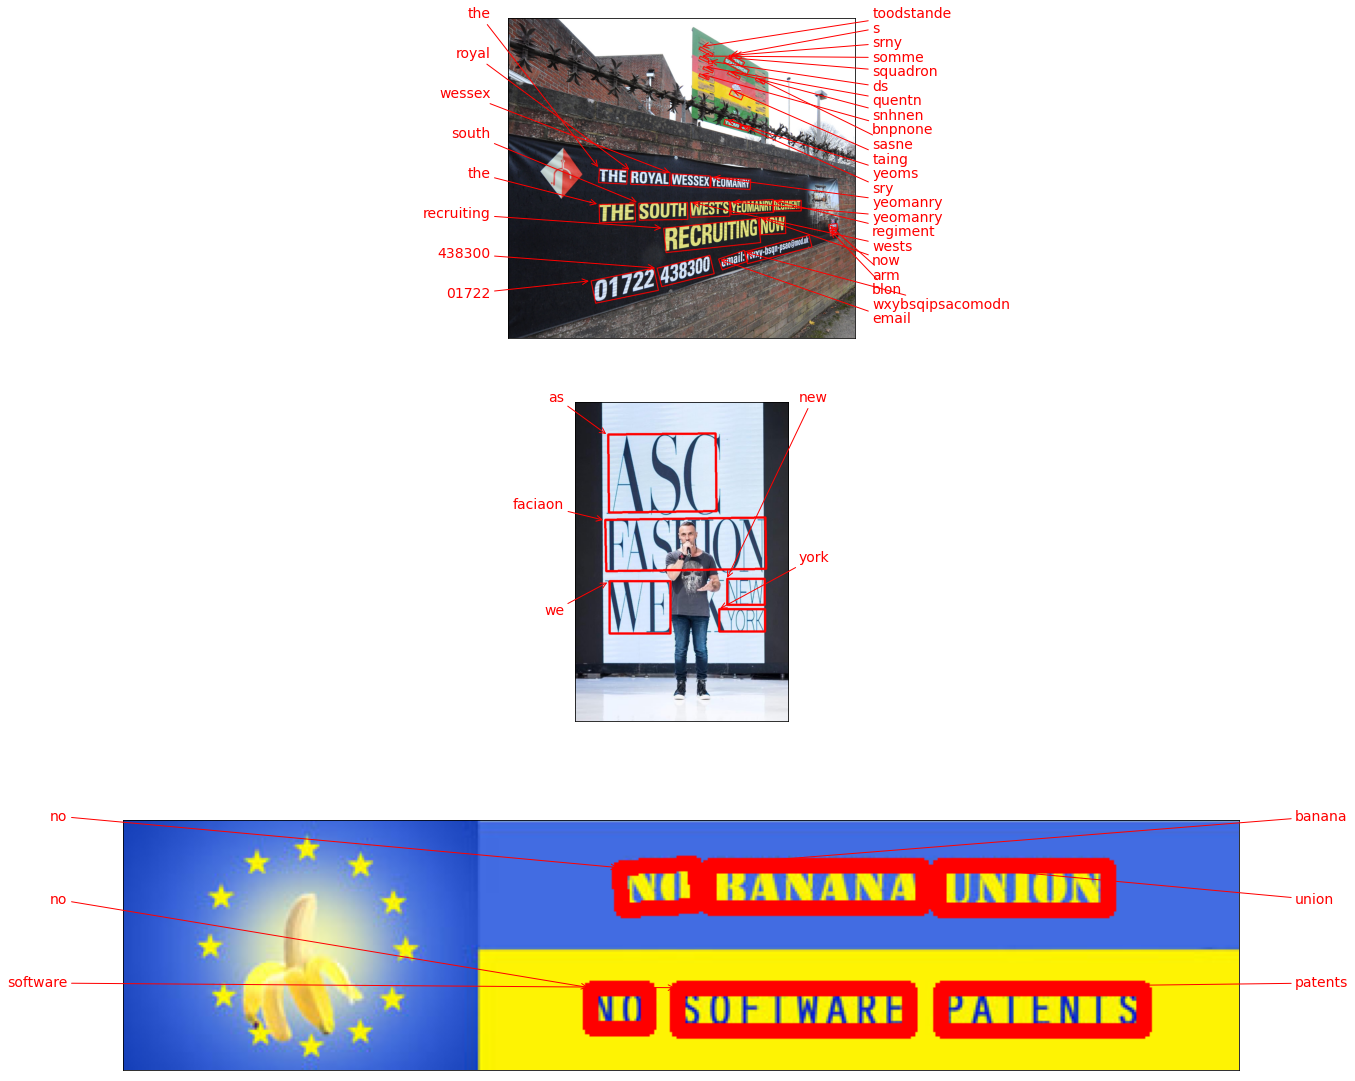

In [5]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

In [6]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/my_image.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/home/aiffel0042/aiffel/ocr_python/0000.png
/home/aiffel0042/aiffel/ocr_python/0001.png
/home/aiffel0042/aiffel/ocr_python/0002.png
/home/aiffel0042/aiffel/ocr_python/0003.png
/home/aiffel0042/aiffel/ocr_python/0004.png
/home/aiffel0042/aiffel/ocr_python/0005.png
/home/aiffel0042/aiffel/ocr_python/0006.png
/home/aiffel0042/aiffel/ocr_python/0007.png
/home/aiffel0042/aiffel/ocr_python/0008.png
/home/aiffel0042/aiffel/ocr_python/0009.png
/home/aiffel0042/aiffel/ocr_python/0010.png
/home/aiffel0042/aiffel/ocr_python/0011.png
/home/aiffel0042/aiffel/ocr_python/0012.png
/home/aiffel0042/aiffel/ocr_python/0013.png
/home/aiffel0042/aiffel/ocr_python/0014.png
/home/aiffel0042/aiffel/ocr_python/0015.png
/home/aiffel0042/aiffel/ocr_python/0016.png
/home/aiffel0042/aiffel/ocr_python/0017.png
/home/aiffel0042/aiffel/ocr_python/0018.png
/home/aiffel0042/aiffel/ocr_python/0019.png
/home/aiffel0042/aiffel/ocr_python/0020.png
/home/aiffel0042/aiffel/ocr_python/0021.png
/home/aiffel0042/aiffel/ocr_pyth

In [7]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

Try

the

API

Upjects

| anes

Web

Text


A 5.


STOW

SS IN

+

— 7

Properties

Sate

Search

verkaufen

His

_

vendre

erie

C

tt i#gpnfeesfs#£[-i 7ji CX <_ 7.

Sinnje um nee © mea a sem ma

puoyuw ous Very

in

a ee

ALO.

minde

Dar

DIS

_

consommer

p

ret

ave

a

COnsumMare

r

entro

stens halt

prer. Cnkro .

Done
